# centre point and blink

In [3]:
#!/usr/bin/env python3
"""
Event‑camera eye‑movement preprocessing — blink + retina center
================================================================
Processes a batch of subjects and appends its windows to master CSVs (`train.csv`, `val.csv`, `test.csv`) under OUT_ROOT.
"""

from __future__ import annotations
import json, csv, os, random, multiprocessing as mp
from pathlib import Path
import h5py, numpy as np, torch, cv2

# ─────────── Paths ────────────────────────────────────────────────────────
TRAIN_RAW_ROOT = Path("/kaggle/input/event-eye/event_data/event_data/train")
TEST_RAW_ROOT  = Path("/kaggle/input/event-eye/event_data/event_data/test")
OUT_ROOT       = Path("/kaggle/working/processed_blink_centre")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# ─────────── Batch parameters ────────────────────────────────────────────
BATCH_SIZE  = 20     # subjects per run
BATCH_INDEX = 0      # which batch (0‑based)

# ─────────── Hyper‑parameters ────────────────────────────────────────────
WIN_SEC       = 0.10
NUM_BINS      = 5
SENSOR_SIZE   = (640, 480)
RESIZE_TO     = (160, 120)

SEED    = 42
WORKERS = max(os.cpu_count() - 1, 1)

CFG = dict(
    win_sec       = WIN_SEC,
    num_bins      = NUM_BINS,
    sensor_size   = RESIZE_TO if RESIZE_TO else SENSOR_SIZE,
    resize        = RESIZE_TO,
)

random.seed(SEED)
np.random.seed(SEED)

# ─────────── I/O helpers ────────────────────────────────────────────────
def load_events_labels(path: Path):
    with h5py.File(path, "r") as f:
        ev = f["events"]
        events = np.column_stack([
            ev["x"].astype(np.int32),
            ev["y"].astype(np.int32),
            ev["t"].astype(np.int64),
            ev["p"].astype(np.int8),
        ])

        if "labels" in f:
            lbl = f["labels"]
            labels = np.column_stack([lbl["t"], lbl["x"], lbl["y"], lbl["close"]])
            return events, labels

    txt = path.with_name("label.txt")
    if not txt.exists():
        return events, None

    rows = []
    for line in txt.read_text().splitlines():
        line = line.strip().lstrip("(").rstrip(")")
        if not line:
            continue
        parts = [p.strip() for p in line.split(",")]
        if len(parts) == 3:
            rows.append(tuple(map(float, parts)))
    if not rows:
        return events, None

    start_t = events[0, 2]
    labels = np.empty((len(rows), 4), np.float64)
    labels[:, 0] = start_t + np.arange(len(rows)) * 10_000
    labels[:, 1:] = np.array(rows, dtype=np.float64)
    return events, labels

# ─────────── Voxel encoder ───────────────────────────────────────────────
def events_to_voxel(events, t0, t1, cfg):
    T, (W, H) = cfg["num_bins"], cfg["sensor_size"]
    vox = np.zeros((T, 2, H, W), np.float32)

    dt = (t1 - t0) / T
    sl = events[(events[:, 2] >= t0) & (events[:, 2] < t1)]
    if sl.size == 0:
        return vox

    bins = ((sl[:, 2] - t0) / dt).astype(np.int32)
    bins[bins == T] = T - 1

    for b, (x, y, p_raw) in zip(bins, sl[:, [0, 1, 3]].astype(int)):
        pol = 1 if p_raw > 0 else 0
        if 0 <= x < W and 0 <= y < H:
            vox[b, pol, y, x] += 1

    vox = np.clip(vox, -3, 3)

    if cfg["resize"]:
        W2, H2 = cfg["resize"]
        small = np.empty((T, 2, H2, W2), np.float32)
        for t in range(T):
            for c in range(2):
                small[t, c] = cv2.resize(vox[t, c], (W2, H2), cv2.INTER_AREA)
        vox = small

    return vox

# ─────────── Core processor (labelled) ───────────────────────────────────
def proc_labelled(args):
    h5, cfg, root = args
    events, labels = load_events_labels(h5)
    if labels is None or len(labels) == 0:
        return None

    subj, sess = h5.parent.name.split("_", 1)
    out_dir = root / subj / sess
    out_dir.mkdir(parents=True, exist_ok=True)

    win_us   = int(cfg["win_sec"] * 1e6)
    lbl_ts   = labels[:, 0].astype(np.int64)
    n_win    = (events[-1, 2] - events[0, 2]) // win_us
    rows     = []

    for w in range(int(n_win)):
        t0 = events[0, 2] + w * win_us
        t1 = t0 + win_us
        idx = np.searchsorted(lbl_ts, t0 + win_us // 2)
        if idx >= len(labels):
            break

        blink = int(labels[idx, 3])
        centre = labels[idx, 1:3]
        voxel = events_to_voxel(events, t0, t1, cfg)
        p = out_dir / f"{w:06d}.pt"

        try:
            torch.save(
                {
                    "x":       torch.from_numpy(voxel),
                    "blink":   torch.tensor(blink, dtype=torch.uint8),
                    "centre":  torch.tensor(centre, dtype=torch.float32),
                },
                p,
                _use_new_zipfile_serialization=False,
            )
            rows.append([subj, sess, w, str(p)])
        except Exception as e:
            print("⚠️", p, e)

    return subj, rows

# ─────────── Core processor (unlabelled test) ────────────────────────────
def proc_unlabelled(args):
    h5, cfg, root = args
    events, _ = load_events_labels(h5)
    subj, sess = h5.parent.name.split("_", 1)
    out_dir = root / subj / sess
    out_dir.mkdir(parents=True, exist_ok=True)

    win_us = int(cfg["win_sec"] * 1e6)
    n_win  = (events[-1, 2] - events[0, 2]) // win_us
    rows   = []

    for w in range(int(n_win)):
        t0 = events[0, 2] + w * win_us
        t1 = t0 + win_us
        voxel = events_to_voxel(events, t0, t1, cfg)
        p = out_dir / f"{w:06d}.pt"
        try:
            torch.save(torch.from_numpy(voxel), p, _use_new_zipfile_serialization=False)
            rows.append([subj, sess, w, str(p)])
        except Exception as e:
            print("⚠️", p, e)
    return rows

# ─────────── CSV helper (append) ─────────────────────────────────────────
def append_csv(name: str, rows: list[list[str]]):
    path = OUT_ROOT / f"{name}.csv"
    exists = path.exists()
    with path.open("a", newline="") as f:
        w = csv.writer(f)
        if not exists:
            w.writerow(["subject", "session", "window", "pt_path"])
        w.writerows(rows)
    return path

# ─────────── Batch driver ───────────────────────────────────────────────
def main():
    subjects = sorted({p.name.split("_", 1)[0] for p in TRAIN_RAW_ROOT.iterdir() if p.is_dir()})
    if not subjects:
        raise RuntimeError("No subject folders found in train dir")

    batches = [subjects[i:i + BATCH_SIZE] for i in range(0, len(subjects), BATCH_SIZE)]
    if BATCH_INDEX >= len(batches):
        raise RuntimeError("BATCH_INDEX too high")

    batch_subj = batches[BATCH_INDEX]
    train_subj, val_subj = batch_subj[:-1], [batch_subj[-1]]
    print("Processing batch", BATCH_INDEX, "→ train", train_subj, "val", val_subj)

    train_h5 = [p for subj in train_subj for p in TRAIN_RAW_ROOT.glob(f"{subj}_*/**/*.h5")]
    val_h5   = [p for subj in val_subj   for p in TRAIN_RAW_ROOT.glob(f"{subj}_*/**/*.h5")]

    with mp.Pool(WORKERS) as pool:
        tr_rows_nested = pool.map(proc_labelled, [(p, CFG, OUT_ROOT) for p in train_h5])
        va_rows_nested = pool.map(proc_labelled, [(p, CFG, OUT_ROOT) for p in val_h5])

    tr_rows = [r for subj_rows in tr_rows_nested if subj_rows for r in subj_rows[1]]
    va_rows = [r for subj_rows in va_rows_nested if subj_rows for r in subj_rows[1]]
    append_csv("train", tr_rows)
    append_csv("val", va_rows)

    test_h5 = list(TEST_RAW_ROOT.rglob("*.h5"))
    with mp.Pool(WORKERS) as pool:
        te_rows_nested = pool.map(proc_unlabelled, [(p, CFG, OUT_ROOT) for p in test_h5])
    te_rows = [r for sub in te_rows_nested for r in sub]
    append_csv("test", te_rows)

    cfg_path = OUT_ROOT / "preproc_cfg.json"
    log = {"cfg": CFG, "batch_size": BATCH_SIZE, "processed_batch": batch_subj}
    if cfg_path.exists():
        prev = json.loads(cfg_path.read_text())
        prev.setdefault("history", []).append(log)
        cfg_path.write_text(json.dumps(prev, indent=2))
    else:
        cfg_path.write_text(json.dumps({"history": [log]}, indent=2))

    print("✅ batch", BATCH_INDEX, "done → CSVs updated in", OUT_ROOT)

if __name__ == "__main__":
    main()


Processing batch 0 → train ['1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8'] val ['9']
✅ batch 0 done → CSVs updated in /kaggle/working/processed_blink_centre


# training code to train the centre of retina and blink

Epoch 01 | TrL 0.170 Acc 0.576 | V L 0.180 Acc 0.734
Epoch 02 | TrL 0.161 Acc 0.617 | V L 0.188 Acc 0.727
Epoch 03 | TrL 0.156 Acc 0.656 | V L 0.177 Acc 0.762
Epoch 04 | TrL 0.152 Acc 0.674 | V L 0.175 Acc 0.786
Epoch 05 | TrL 0.147 Acc 0.711 | V L 0.173 Acc 0.798
Epoch 06 | TrL 0.145 Acc 0.698 | V L 0.157 Acc 0.831
Epoch 07 | TrL 0.143 Acc 0.707 | V L 0.157 Acc 0.828
Epoch 08 | TrL 0.141 Acc 0.715 | V L 0.156 Acc 0.826
Epoch 09 | TrL 0.136 Acc 0.727 | V L 0.158 Acc 0.821
Epoch 10 | TrL 0.133 Acc 0.744 | V L 0.146 Acc 0.847
Epoch 11 | TrL 0.132 Acc 0.737 | V L 0.145 Acc 0.849
Epoch 12 | TrL 0.128 Acc 0.759 | V L 0.146 Acc 0.842
Epoch 13 | TrL 0.127 Acc 0.752 | V L 0.147 Acc 0.835
Epoch 14 | TrL 0.123 Acc 0.783 | V L 0.131 Acc 0.887
Epoch 15 | TrL 0.122 Acc 0.789 | V L 0.147 Acc 0.840
Epoch 16 | TrL 0.118 Acc 0.792 | V L 0.135 Acc 0.866
Epoch 17 | TrL 0.118 Acc 0.792 | V L 0.131 Acc 0.875
Epoch 18 | TrL 0.116 Acc 0.802 | V L 0.126 Acc 0.887
Epoch 19 | TrL 0.113 Acc 0.824 | V L 0.124 Acc

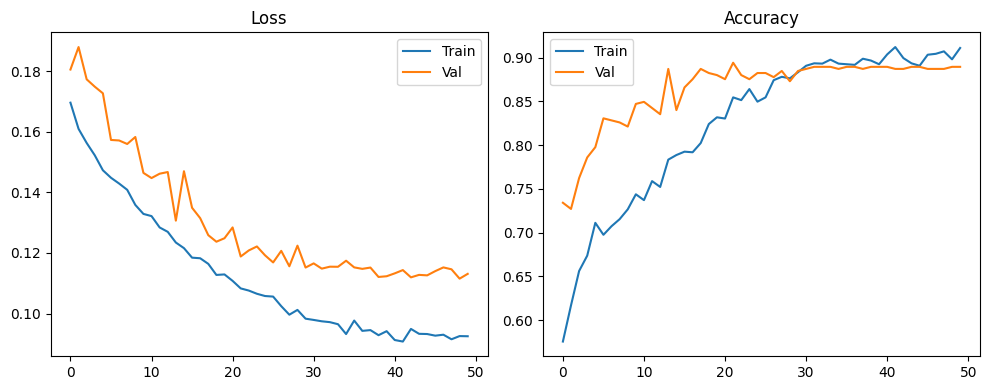

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import snntorch as snn
from snntorch import surrogate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ─────────── Config ───────────────────────────────────────────────────────
IMAGE_W, IMAGE_H       = 160, 120
TRAIN_CSV              = Path("processed_blink_centre/train.csv")
VAL_CSV                = Path("processed_blink_centre/val.csv")
DEVICE                 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH                  = 8
EPOCHS                 = 50
LR                     = 1e-5
EMA_DECAY              = 0.995
CENTRE_WEIGHT          = 0.001
SWA_START              = 10
BLINK_ONLY_EPOCHS      = 5
FOCAL_ALPHA            = 0.5
FOCAL_GAMMA            = 1.0

# ─────────── Focal Loss ───────────────────────────────────────────────────
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce   = nn.functional.binary_cross_entropy_with_logits(
                   inputs, targets.float(), reduction='none')
        probs = torch.sigmoid(inputs)
        p_t   = probs * targets + (1 - probs) * (1 - targets)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss  = alpha_t * (1 - p_t)**self.gamma * bce
        return loss.mean()

# ─────────── Dataset ──────────────────────────────────────────────────────
class BlinkCentreDataset(Dataset):
    def __init__(self, csv_file):
        df    = pd.read_csv(csv_file)
        paths = df["pt_path"].tolist()
        self.paths  = [p for p in paths
                       if torch.load(p, weights_only=True)["x"].abs().sum() > 0]
        self.blinks = [int(torch.load(p, weights_only=True)["blink"].item())
                       for p in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        d      = torch.load(self.paths[idx], weights_only=True)
        x      = d["x"].float().div(3.0).permute(1,0,2,3)  # (2,T,H,W)
        cnt    = x.abs().sum(dim=(0,1), keepdim=True)     # (1,H,W)
        blink  = d["blink"].float().unsqueeze(0)
        centre = d["centre"].float()
        centre = torch.tensor([
            centre[0].clamp(0, IMAGE_W)/IMAGE_W,
            centre[1].clamp(0, IMAGE_H)/IMAGE_H
        ])
        return x, cnt, blink, centre

# ─────────── Model ─────────────────────────────────────────────────────────
class SpikingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, 3, padding=1); self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64,128, 3, padding=1); self.bn3 = nn.BatchNorm3d(128)
        self.pool  = nn.AdaptiveAvgPool3d(1)
        self.act   = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid())
        self.fc1   = nn.Linear(128 + IMAGE_H*IMAGE_W, 64)
        self.drop  = nn.Dropout(0.4)
        self.blink_head  = nn.Linear(64, 1)
        self.centre_head = nn.Linear(64, 2)

    def forward(self, x, cnt):
        out, _ = self.act(self.bn1(self.conv1(x)))
        out, _ = self.act(self.bn2(self.conv2(out)))
        out, _ = self.act(self.bn3(self.conv3(out)))
        feat    = self.pool(out).view(out.size(0), -1)
        cnt_flat= cnt.view(out.size(0), -1)
        h       = torch.cat([feat, cnt_flat], dim=1)
        h       = torch.relu(self.fc1(h))
        h       = self.drop(h)
        return self.blink_head(h), self.centre_head(h)

# ─────────── EMA Helper ────────────────────────────────────────────────────
class EMA:
    def __init__(self, model, decay):
        self.decay  = decay
        self.shadow = {n: p.clone().detach()
                       for n,p in model.named_parameters()}

    def update(self, model):
        for n,p in model.named_parameters():
            self.shadow[n].mul_(self.decay).add_(p.data, alpha=1-self.decay)

    def apply(self, model):
        for n,p in model.named_parameters():
            p.data.copy_(self.shadow[n])

# ─────────── Train Loop ────────────────────────────────────────────────────
def train():
    train_ds = BlinkCentreDataset(TRAIN_CSV)
    val_ds   = BlinkCentreDataset(VAL_CSV)
    counts   = np.bincount(train_ds.blinks, minlength=2)
    sampler  = WeightedRandomSampler(
        [1.0/(counts[b]+1e-6) for b in train_ds.blinks],
        len(train_ds), replacement=True
    )
    train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler)
    val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

    model     = SpikingCNN().to(DEVICE)
    ema       = EMA(model, EMA_DECAY)
    opt       = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    sched     = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    blink_loss_fn  = BinaryFocalLoss()
    centre_loss_fn = nn.MSELoss()
    hist = {'tr_loss':[], 'tr_acc':[], 'val_loss':[], 'val_acc':[]}

    for ep in range(1, EPOCHS+1):
        # — Training —
        model.train()
        tl = ta = 0
        for x,cnt,blink,centre in train_loader:
            x, cnt       = x.to(DEVICE), cnt.to(DEVICE)
            blink, centre= blink.to(DEVICE), centre.to(DEVICE)
            out_b, out_c = model(x, cnt)
            lb = blink_loss_fn(out_b, blink.int())
            lc = centre_loss_fn(out_c, centre)
            cw = 0.0 if ep<=BLINK_ONLY_EPOCHS else CENTRE_WEIGHT
            loss = lb + cw*lc

            opt.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            ema.update(model)

            ta += (torch.sigmoid(out_b).round()==blink).sum().item()
            tl += loss.item() * blink.size(0)

        hist['tr_loss'].append(tl/len(train_ds))
        hist['tr_acc'].append(ta/len(train_ds))

        # — Validation —
        model.eval()
        vl = va = 0
        with torch.no_grad():
            for x,cnt,blink,centre in val_loader:
                x, cnt       = x.to(DEVICE), cnt.to(DEVICE)
                blink, centre= blink.to(DEVICE), centre.to(DEVICE)
                out_b, out_c = model(x, cnt)
                lb = blink_loss_fn(out_b, blink.int())
                lc = centre_loss_fn(out_c, centre)
                loss = lb + CENTRE_WEIGHT*lc

                va += (torch.sigmoid(out_b).round()==blink).sum().item()
                vl += loss.item() * blink.size(0)

        hist['val_loss'].append(vl/len(val_ds))
        hist['val_acc'].append(va/len(val_ds))

        print(f"Epoch {ep:02d} | TrL {hist['tr_loss'][-1]:.3f} Acc {hist['tr_acc'][-1]:.3f} | "
              f"V L {hist['val_loss'][-1]:.3f} Acc {hist['val_acc'][-1]:.3f}")
        sched.step()

    # — Apply EMA smoothing —
    ema.apply(model)

    # ─────────── Save Model ────────────────────────────────────────────────
    save_path = Path("blink_centre_model.pth")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Model weights saved to {save_path}")

    # ─────────── Plot ───────────────────────────────────────────────────────
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist['tr_loss'], label='Train')
    plt.plot(hist['val_loss'], label='Val')
    plt.title('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist['tr_acc'], label='Train')
    plt.plot(hist['val_acc'], label='Val')
    plt.title('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

if __name__=="__main__":
    train()


# Inference testing 

In [24]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import snntorch as snn
from snntorch import surrogate

# Try importing dv.AedatFile for AEDAT4 parsing
try:
    from dv import AedatFile
except ImportError:
    raise ImportError("Please install the dv package (e.g. `pip install dv`) to read AEDAT4 files.")

# ─────────── Configuration ─────────────────────────────────────────────────
# Paths
AEDAT_PATH      = Path("/kaggle/input/aedat4-1/events.aedat4")
MODEL_PATH      = Path("/kaggle/input/blink/pytorch/default/1/blink_centre_model (1).pth")
OUTPUT_VIDEO    = Path("output_predictions.mp4")

# Voxel parameters
NUM_BINS        = 5
SENSOR_W, SENSOR_H = 346, 260    # your sensor resolution
RESIZE_W, RESIZE_H = 160, 120
WIN_MS          = 100.0           # window length in milliseconds

# Inference / Video parameters
FPS             = int(1000.0 / WIN_MS)
BLINK_THRESH    = 0.5             # blink decision threshold

DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─────────── Model Definition ──────────────────────────────────────────────
class SpikingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(2,  32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, 3, padding=1); self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(64,128, 3, padding=1); self.bn3 = nn.BatchNorm3d(128)
        self.pool  = nn.AdaptiveAvgPool3d(1)
        self.act   = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid())
        self.fc1   = nn.Linear(128 + RESIZE_W*RESIZE_H, 64)
        self.drop  = nn.Dropout(0.4)
        self.blink_head  = nn.Linear(64, 1)
        self.centre_head = nn.Linear(64, 2)

    def forward(self, x, cnt):
        out, _ = self.act(self.bn1(self.conv1(x)))
        out, _ = self.act(self.bn2(self.conv2(out)))
        out, _ = self.act(self.bn3(self.conv3(out)))
        feat     = self.pool(out).view(out.size(0), -1)       # (N,128)
        cnt_flat = cnt.view(out.size(0), -1)                 # (N,RESIZE_W*RESIZE_H)
        h        = torch.cat([feat, cnt_flat], dim=1)
        h        = torch.relu(self.fc1(h))
        h        = self.drop(h)
        return self.blink_head(h), self.centre_head(h)

# ─────────── Read AEDAT4 events ────────────────────────────────────────────
def read_aedat4(path: Path) -> np.ndarray:
    """
    Parse .aedat4 into an (N,4) array [x, y, t_us, polarity].
    Requires the dv package.
    """
    chunks = []
    with AedatFile(str(path)) as f:
        for packet in f['events']:
            xs = packet.x
            ys = packet.y
            ts = packet.timestamp   # in µs
            ps = packet.polarity
            ev = np.column_stack([xs, ys, ts, ps])
            chunks.append(ev)
    if not chunks:
        return np.zeros((0,4), dtype=np.int64)
    return np.vstack(chunks).astype(np.int64)

# ─────────── Voxel Encoding ────────────────────────────────────────────────
def events_to_voxel(events: np.ndarray, t0: int, t1: int) -> np.ndarray:
    """
    Bin events into a (NUM_BINS, 2, SENSOR_H, SENSOR_W) voxel grid,
    then downsample to (NUM_BINS, 2, RESIZE_H, RESIZE_W).
    """
    T = NUM_BINS
    vox = np.zeros((T, 2, SENSOR_H, SENSOR_W), np.float32)
    dt  = (t1 - t0) / T
    mask = (events[:,2] >= t0) & (events[:,2] < t1)
    sl   = events[mask]
    if sl.size:
        bins = ((sl[:,2] - t0) / dt).astype(int)
        np.clip(bins, 0, T-1, out=bins)
        for b, (x, y, p) in zip(bins, sl[:, [0,1,3]].astype(int)):
            if 0 <= x < SENSOR_W and 0 <= y < SENSOR_H:
                vox[b, p, y, x] += 1
    vox = np.clip(vox, -3, 3)

    # downsample each frame
    small = np.zeros((T, 2, RESIZE_H, RESIZE_W), np.float32)
    for t in range(T):
        for c in range(2):
            small[t, c] = cv2.resize(
                vox[t, c], (RESIZE_W, RESIZE_H),
                interpolation=cv2.INTER_AREA
            )
    return small

# ─────────── Main Inference & Video Save ──────────────────────────────────
def main():
    # 1) Load all events
    events = read_aedat4(AEDAT_PATH)
    if events.shape[0] == 0:
        print("No events found in AEDAT4 file.")
        return

    # 2) Load trained model
    model = SpikingCNN().to(DEVICE)
    state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
    model.load_state_dict(state)
    model.eval()

    # 3) Setup video writer at FPS
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(
        str(OUTPUT_VIDEO), fourcc, FPS,
        (RESIZE_W, RESIZE_H)
    )

    # 4) Slide 100 ms windows
    win_us = int(WIN_MS * 1000)
    t0     = int(events[0,2])
    t_end  = int(events[-1,2])
    n_win  = (t_end - t0) // win_us

    for _ in range(int(n_win)):
        t1  = t0 + win_us
        vox = events_to_voxel(events, t0, t1)          # (T,2,H,W)
        t0 += win_us

        # 5) Prepare torch tensors
        x   = torch.from_numpy(vox) \
                 .permute(1,0,2,3).unsqueeze(0) \
                 .to(DEVICE)                       # (1,2,T,H,W)
        cnt = x.abs().sum(dim=(1,2), keepdim=True)     # (1,1,H,W)

        # 6) Inference
        with torch.no_grad():
            blink_logit, centre = model(x, cnt)
            prob  = torch.sigmoid(blink_logit).item()
        label = "blink" if prob > BLINK_THRESH else "open"

        # 7) Decode centre → pixel coords
        cx = int(centre[0,0].clamp(0,1).item() * RESIZE_W)
        cy = int(centre[0,1].clamp(0,1).item() * RESIZE_H)

        # 8) Render event‐count map
        cm     = cnt.squeeze().cpu().numpy()           # (H,W)
        cm_img = (cm / (cm.max()+1e-6) * 255).astype(np.uint8)
        frame  = cv2.cvtColor(cm_img, cv2.COLOR_GRAY2BGR)

        # 9) Overlay red dot + label
        cv2.circle(frame, (cx, cy), 3, (0,0,255), -1)
        cv2.putText(frame, label, (5,20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                    (255,255,255), 1, cv2.LINE_AA)

        # 10) Write to video
        writer.write(frame)

    writer.release()
    print(f"✅ Saved prediction video to {OUTPUT_VIDEO.resolve()}")

if __name__ == "__main__":
    main()


✅ Saved prediction video to /kaggle/working/output_predictions.mp4
